# Module Test Template

## Module & Test Description

This Notebook is used to evaulate c and z (ratio of steel_strain to yield_strain) relationships. Positive z values values signify the steel is in compression; negative values correspond to tension.

c ranges from 0 (pure tension) to infinite (pure compression).

### Imports
##### General Imports

In [1]:
import os, sys, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import shapely as sh

##### Extend PYPATH to current folder:
This allows importing libraries from the same folder; <code>pathlib.Path().resolve()</code> returns the path of the current directory.

In [2]:
sys.path.extend([pathlib.Path().resolve()])

Import specific testing modules:

In [3]:
import rccolumn
import rcmaterials
import rcutilities

rcmaterials <version 0.0.6> successfully imported
rccolumn <version 0.0.4> successfully imported
rcutilities <version 0.0.1> successfully imported


## Input Values for Test Column Section

In [4]:
c_comp = rccolumn.CCOMP
c_tens = rccolumn.CTENS

conc = rcmaterials.ConcreteMaterial(5000)
bw = 16
h = 16

rebar = rcmaterials.RebarMaterial(60000)
layer_distances = np.array([2.5, 13.5])
layer_bar_sizes = np.array([9, 9])
layer_bar_counts = np.array([4, 4])

In [5]:
# Create function for returning array with total layer area by layer:
def get_layer_areas(layer_bar_sizes, layer_bar_counts, rebar: rcmaterials.RebarMaterial):
    layers = layer_bar_counts.shape[0]
    layer_areas = np.zeros(layers)
    for i in range(layers):
        layer_areas[i] = rebar.bar_areas[layer_bar_sizes[i]] * layer_bar_counts[i]
    return layer_areas

In [6]:
layer_areas = get_layer_areas(layer_bar_sizes, layer_bar_counts, rebar)
layer_areas

array([4., 4.])

<span style="color: orange;">**TODO**:</span>
- [ ]  In the US you'll generally use the same grade of bar everywhere, but in Japan, there are three common grades. As a code enchancement, need to expand the ability to have different layer fy and ey properties.

In [7]:
# Calculate other attributes of column, determined from factors above:

In [8]:
d = max(layer_distances)

Ag = bw * h
Astl = sum(layer_areas)
rho = Astl / Ag

Ag, Astl, rho

(256, 8.0, 0.03125)

<span style="color: tomato;">**TODO**:</span> 
- [X] Create function to calculate the column *rho*.
- [X] Create function to return d and d'.

## Test Code at Pure Axial and Pure Moment Points
Compare the following simple functions to the *pm_points()* output (all four are from *rccolumn.py*)

In [9]:
# Pure Compression
Po = rccolumn.Po(bw * h, layer_areas, conc, rebar)
Po / 1000

1534.0

In [10]:
# Compare with get_pm
P, M, strains = rccolumn.pm_points(c_comp, bw, h, layer_distances, layer_areas, conc, rebar)
P / 1000, M / 12000

(1534.0, 0.0)

In [11]:
# Pure Tension
Pnt = rccolumn.Pntmax(bw * h, layer_areas, conc, rebar)
Pnt / 1000

-480.0

In [12]:
# Compare with get_pm
P, M, strains = rccolumn.pm_points(c_tens, bw, h, layer_distances, layer_areas, conc, rebar)
P / 1000, M / 12000

(-480.0, 0.0)

In [13]:
# Pure Moment Case
# First need to calculate the Z ratio, then calculate c from Z:
z_m = rccolumn.get_z_at_pure_m(bw, h, layer_distances, layer_areas, conc, rebar)
c_m = rccolumn.c_from_z(z_m, d, conc, rebar)

# Next we can calculate the P and M
P, M, strains = rccolumn.pm_points(c_m, bw, h, layer_distances, layer_areas, conc, rebar)

round(P / 1000, 3), round(M / 12000, 3)

(-0.0, 237.68)

<span style="color: dodgerblue;">**CONCLUSION**:</span> The above functions are working as planned.

## Investigate range of c values between *c<sub>max</sub>* and *Z* = 0
On a PM diagram, strain has a non-linear relationship with the rotation angle of a line segment from the origin to the corresponding point on the PM curve. Near c -> inf for pure compression; the strain is limited to concrete.ecu. We'll probably need a geometric distribution of c values in this range to get a reasonable distribution of PM points.

In [14]:
# One option is to traverse valuse from c_max down to c at z = 0:
c_max = rccolumn.CCOMP
c_at_Z_0 = rccolumn.c_from_z(z=0, layer_distance=d, concrete=conc, rebar=rebar)
c_max, c_at_Z_0

(inf, 13.5)

In [15]:
# Another option is to stay in the z-domain
z_max = rccolumn.max_z(conc, rebar)
z_max, 0

(1.45, 0)

In [16]:
# Determine how many points over this range to calculate
points = 10

# Use linspace to develope a linear distribution over the z-domain
zs = np.linspace(z_max, 0, points)
cs_at_zs = np.zeros(points)
for i in range(points):
    cs_at_zs[i] = rccolumn.c_from_z(zs[i], d, conc, rebar)

# Print the values
zs, cs_at_zs

(array([1.45      , 1.28888889, 1.12777778, 0.96666667, 0.80555556,
        0.64444444, 0.48333333, 0.32222222, 0.16111111, 0.        ]),
 array([         inf, 121.5       ,  60.75      ,  40.5       ,
         30.375     ,  24.3       ,  20.25      ,  17.35714286,
         15.1875    ,  13.5       ]))

In [17]:
P = np.zeros(points)
M = np.zeros(points)
strains = np.zeros(points)
for i in range(points):
    P[i], M[i], strains[i] = rccolumn.pm_points(cs_at_zs[i], bw, h, layer_distances, layer_areas, conc, rebar)

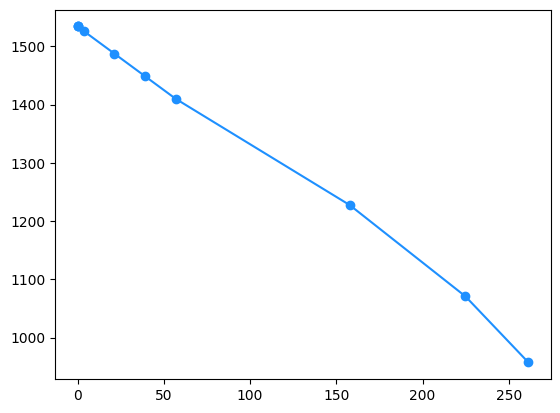

In [18]:
# Plot the values
plt.plot(M / 12000, P / 1000, color="dodgerblue")
plt.scatter(M / 12000, P / 1000, color="dodgerblue")

In [19]:
# Next let's try a geometric distribution
zs = np.geomspace(z_max, 0.001, points)
for i in range(points):
    cs_at_zs[i] = rccolumn.c_from_z(zs[i], d, conc, rebar)

# Print the values
zs, cs_at_zs

(array([1.45000000e+00, 6.45810186e-01, 2.87635032e-01, 1.28108713e-01,
        5.70578702e-02, 2.54127957e-02, 1.13185120e-02, 5.04111056e-03,
        2.24524176e-03, 1.00000000e-03]),
 array([        inf, 24.34126828, 16.84066584, 14.80832818, 14.05298869,
        13.74082256, 13.6062083 , 13.54709822, 13.52093639, 13.50931677]))

<span style="color: tomato;">**WARNING**:</span> Geomspace **CANNOT** zero can not be a terminal for *geomspace*, so if you use it, you must back off of Z = 0 some amount.

In [20]:
Pg = np.zeros(points)
Mg = np.zeros(points)
strainsg = np.zeros(points)
for i in range(points):
    Pg[i], Mg[i], strainsg[i] = rccolumn.pm_points(cs_at_zs[i], bw, h, layer_distances, layer_areas, conc, rebar)

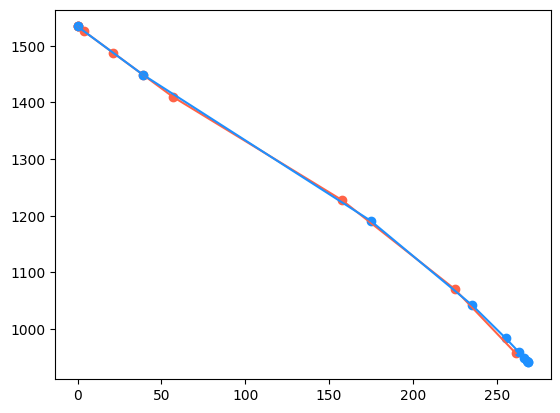

In [21]:
# Plot the values
plt.plot(M / 12000, P / 1000, color="tomato")
plt.scatter(M / 12000, P / 1000, color="tomato")

plt.plot(Mg / 12000, Pg / 1000, color="dodgerblue")
plt.scatter(Mg / 12000, Pg / 1000, color="dodgerblue")

<span style="color: dodgerblue;">**NOTE**:</span> The *linspace* distribution seems to do better closer to z = 0, while *geomspace* does better closer to c = inf.

### Calculate intermediate points by equal spacing between Po and P(z=0)
An alternative to c- or z-domain points, we could calculate Po and P(z = 0) and then divide that value into equal regions, findign the z or c for the intermiate P values.

In [22]:
points = 7 # This will include Po and P(z=0)

# We already calculated Po above, so let's get P(z=0)
P_at_Z_0 = rccolumn.pm_points(c_at_Z_0, bw, h, layer_distances, layer_areas, conc, rebar)[0]

# Let's create a linspace of P values:
Ps = np.linspace(Po, P_at_Z_0, points)
Ps

array([1534000., 1437900., 1341800., 1245700., 1149600., 1053500.,
        957400.])

In [23]:
# Get the z arrays:
zs = np.zeros(points)
cs = np.zeros(points)
for i in range(points):
    zs[i] = rccolumn.get_z_at_p(Ps[i], bw, h, layer_distances, layer_areas, conc, rebar)
    cs[i] = rccolumn.c_from_z(zs[i], d, conc, rebar)

In [24]:
# The following code was used for ensuring the extrema were included however, it doesn't appear this is really necessary

# expanded_zs = zs.copy()
# expanded_zs = np.insert(expanded_zs, 0, z_max)
# expanded_zs = np.append(expanded_zs, 0)
# expanded_zs

In [25]:
# Next we need to get the c array:
# cs = np.zeros(expanded_zs.shape[0])
# for i in range(expanded_zs.shape[0]):
#    cs[i] = rccolumn.c_from_z(expanded_zs[i], d, conc, rebar)
# cs

In [26]:
zs

array([1.21777344, 0.59958333, 0.42091265, 0.33886591, 0.24611098,
       0.14117817, 0.02253215])

In [27]:
cs

array([84.29268293, 23.01812837, 19.0217089 , 17.61713568, 16.25980448,
       14.95619923, 13.71309345])

In [28]:
# We can see the c values as a multiple of the total section depth --- for comparison
cs / h

array([5.26829268, 1.43863302, 1.18885681, 1.10107098, 1.01623778,
       0.93476245, 0.85706834])

In [29]:
# let's test with pm_points:
Pp = np.zeros(points)
Mp = np.zeros(points)
strainsp = np.zeros(points)
for i in range(points):
    Pp[i], Mp[i], strainsp[i] = rccolumn.pm_points(cs[i], bw, h, layer_distances, layer_areas, conc, rebar)

In [30]:
Pp / 1000, Mp / 12000

(array([1534. , 1437.9, 1341.8, 1245.7, 1149.6, 1053.5,  957.4]),
 array([  0.        ,  44.04583333,  97.44350885, 148.84711212,
        193.20538251, 231.2611759 , 263.85425582]))

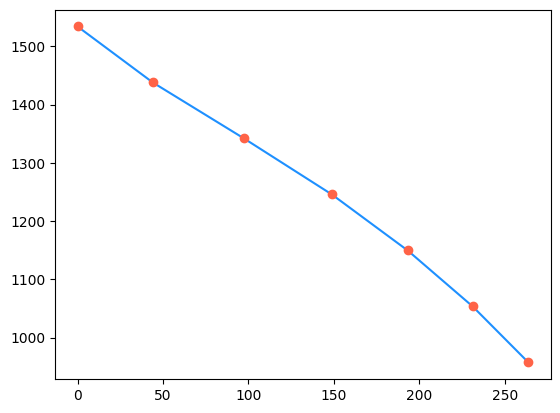

In [31]:
# Plot the values
plt.scatter(Mp / 12000, Pp / 1000, color="tomato", zorder = 10)
plt.plot(Mp / 12000, Pp / 1000, color="dodgerblue")

<span style="color: dodgerblue;">**CONCLUSION**:</span> Rather than using the z- or c- domains to get a distribution of points over the range from pure compression to P(z=0), just calculate the interval boundaries [Po, P(z=0)] --> z --> c --> pm_points()

<span style="color: tomato;">**TODO**:</span>
- [x] Create a function to evenly space points along the positive Z region.

In [32]:
def test_equally_spaced_positive_zs(bw, h, 
                       layer_distances, layer_areas, 
                       concrete: rcmaterials.ConcreteMaterial, 
                       rebar: rcmaterials.RebarMaterial, 
                       points: int = 5):
    Po = rccolumn.Po(bw * h, layer_areas, concrete, rebar)

    c_at_z_0 = rccolumn.c_from_z(0, max(layer_distances), concrete, rebar)
    P_at_z_0 = rccolumn.pm_points(c_at_z_0, bw, h, layer_distances, layer_areas, conc, rebar)[0]
    Ps = np.linspace(Po, P_at_z_0, points)
                           
    zs = np.zeros(points)
    cs = np.zeros(points)
    for i in range(points):
        zs[i] = rccolumn.get_z_at_p(Ps[i], bw, h, layer_distances, layer_areas, concrete, rebar)
    return zs

In [33]:
# Time to test:
zs_2 = test_equally_spaced_positive_zs(bw, h, layer_distances, layer_areas, conc, rebar, points)
zs_2

array([1.21777344, 0.59958333, 0.42091265, 0.33886591, 0.24611098,
       0.14117817, 0.02253215])

In [34]:
# Check if it's true
zs == zs_2

array([ True,  True,  True,  True,  True,  True,  True])

## Calculate Capped Maximum Axial Capacity
In the last section we determined a strategy for getting equidistance points between Zmax and Z = 0, however, we need to determine where the capped axial max occurs. Per ACI 318 Table 22.4.2.1 --- by default assume Pnmax = 0.8Po, except where <code>has_spirals == True</code> or <code>is_ch_10_composite == True</code>, where Pnmax = 0.85P0.

In [35]:
# Pure Compression
Po = rccolumn.Po(bw * h, layer_areas, conc, rebar)
Po / 1000

1534.0

In [36]:
# Capped Maximum Compression
Pn =  rccolumn.Pnmax(bw * h, layer_areas, conc, rebar)
Pn / 1000

1227.2

In [37]:
z_at_capped_compression = rccolumn.get_z_at_p(Pn, bw, h, layer_distances, layer_areas, conc, rebar)
z_at_capped_compression

0.3218861910586853

<span style="color: dodgerblue;">**OBSERVATION**:</span> In the case of this column, 0.8Po appears to occur within the positive z region. Therefore, perhaps the function in the previous section should be revised to:
1. Check if capped max is in the positive z region (most likely)
2. Create two regions: zmax -> capped max, then capped max to z = 0

<span style="color: dodgerblue;">**NOTE**:</span> there is a potential to repeate the capped max point, this could be removed afterwards or avoided before had.

<span style="color: tomato;">**TODO**:</span>
- [ ] Modify equally_spaced_positive_zs() to have two regions.

In [38]:
# Test module function results
points = 10

p_capped = rccolumn.Pnmax(bw * h, layer_areas, conc, rebar, has_spirals = False, is_ch_10_composite = False)
z_at_p_capped = rccolumn.get_z_at_p(p_capped, bw, h, layer_distances, layer_areas, conc, rebar)
p_capped / 1000, z_at_p_capped

(1227.2, 0.3218861910586853)

In [39]:
a_range_step = (Po - p_capped) / 5
a_range_step

61360.0

In [40]:
ps_a = np.arange(Po, p_capped, -a_range_step)
ps_a

array([1534000., 1472640., 1411280., 1349920., 1288560.])

In [41]:
# Get P at Z=0 (calculated previously)
P_at_Z_0

957400.0

In [42]:
ps_b = np.linspace(p_capped, P_at_Z_0, points - 5)
ps_b

array([1227200., 1159750., 1092300., 1024850.,  957400.])

In [43]:
ps = np.hstack((ps_a, ps_b))
ps / 1000

array([1534.  , 1472.64, 1411.28, 1349.92, 1288.56, 1227.2 , 1159.75,
       1092.3 , 1024.85,  957.4 ])

In [44]:
new_zs = rccolumn.get_positive_zs(bw, h, layer_distances, layer_areas, conc, rebar, points = 9, has_spirals = False, is_ch_10_composite = False)
new_zs

array([1.21777344, 0.74433333, 0.48866667, 0.42739874, 0.37669739,
       0.32188619, 0.25645653, 0.18510782, 0.10731137, 0.02253215])

In [45]:
points = new_zs.shape[0]

new_cs = np.zeros(points)
new_Ps = np.zeros(points)
new_Ms = np.zeros(points)
new_strainss = np.zeros(points)
for i in range(points):
    new_cs[i] = rccolumn.c_from_z(new_zs[i], d, conc, rebar)
    new_Ps[i], new_Ms[i], new_strainss[i] = rccolumn.pm_points(new_cs[i], bw, h, layer_distances, layer_areas, conc, rebar)

In [46]:
new_Ps / 1000

array([1534.  , 1472.64, 1411.28, 1349.92, 1288.56, 1227.2 , 1159.75,
       1092.3 , 1024.85,  957.4 ])

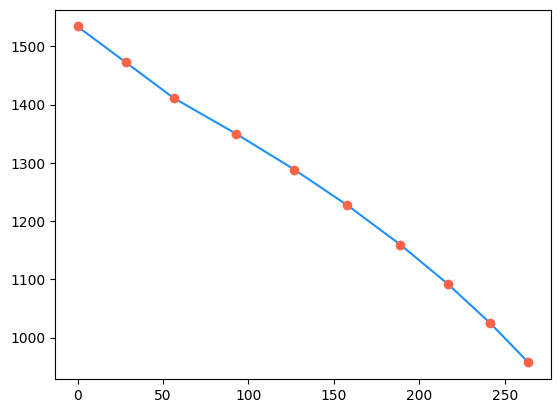

In [47]:
# Plot the values
plt.scatter(new_Ms / 12000, new_Ps / 1000, color="tomato", zorder= 10)
plt.plot(new_Ms / 12000, new_Ps / 1000, color="dodgerblue")

In [48]:
# Let's determine the index of the value that is the capped maximum.
p_capped_index = np.where(new_Ps == p_capped)[0]
p_capped_index

array([], dtype=int64)

In [49]:
# NOTE: nothing is returned because the array calculated value is ever so slightly different.
# We could handle this by rounding the answer inside pm_points, which may be sensible given the
# precision. Or we could create a function to find the nearest value.
new_Ps, p_capped

(array([1534000.        , 1472639.99999975, 1411280.00000022,
        1349920.00000109, 1288559.99999989, 1227199.99999905,
        1159749.99999838, 1092299.99999851, 1024850.0000007 ,
         957399.99999937]),
 1227200.0)

In [50]:
def find_nearest(array, value, as_index: bool = True):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    if as_index:
        return index
    else:
        return array[index]

In [51]:
capped_index = find_nearest(new_Ps, p_capped)
capped_index

5

In [52]:
Pcap = new_Ps[capped_index]
Mcap = new_Ms[capped_index]

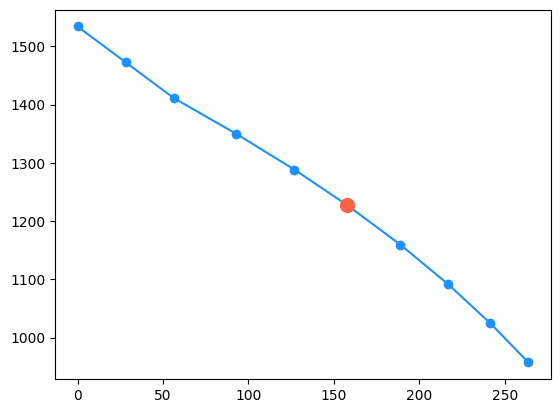

In [53]:
# Plot the values WITH the capped values highlighted
plt.scatter(new_Ms / 12000, new_Ps / 1000, color="dodgerblue")
plt.plot(new_Ms / 12000, new_Ps / 1000, color="dodgerblue")

# Highlight the capped value
plt.scatter(Mcap / 12000, Pcap / 1000, color="tomato", s = 100, zorder = 10)

## Create List of Zs between Z = 0 and Pure Bending

In [54]:
# create range between es = -0.003 through -0.005
cardinal_strains = np.arange(-0.0030, -0.00505, -0.0001)
cardinal_strains

array([-0.003 , -0.0031, -0.0032, -0.0033, -0.0034, -0.0035, -0.0036,
       -0.0037, -0.0038, -0.0039, -0.004 , -0.0041, -0.0042, -0.0043,
       -0.0044, -0.0045, -0.0046, -0.0047, -0.0048, -0.0049, -0.005 ])

In [55]:
zs_strains = rccolumn.zs_from_strains(cardinal_strains, rebar)
zs_strains

array([-1.45      , -1.49833333, -1.54666667, -1.595     , -1.64333333,
       -1.69166667, -1.74      , -1.78833333, -1.83666667, -1.885     ,
       -1.93333333, -1.98166667, -2.03      , -2.07833333, -2.12666667,
       -2.175     , -2.22333333, -2.27166667, -2.32      , -2.36833333,
       -2.41666667])

In [56]:
# Next we need to determined the range between Z at es = -0.005 and Z at Mmax
# We can assume there will be say n number of points over this range.
z_Mmax = rccolumn.get_z_at_pure_m(bw, h, layer_distances, layer_areas, conc, rebar)
z_Mmax

-4.574536344416801

In [57]:
points = 9
spaces = points - 1
distance = zs_strains[-1] - z_Mmax
step_distance = distance / spaces
distance, step_distance, step_distance * spaces == distance

(2.157869677750136, 0.269733709718767, True)

In [58]:
# Using numpy.linspace, we cans start one step past es = -0.005
zs_bal_to_pure_m = np.linspace(zs_strains[-1] - step_distance, z_Mmax, points)
zs_bal_to_pure_m

array([-2.68640038, -2.92241737, -3.15843437, -3.39445136, -3.63046836,
       -3.86648536, -4.10250235, -4.33851935, -4.57453634])

In [59]:
# Test function zs_from_zero_to_pure_m
zs_part_2 = rccolumn.get_zs_from_zero_to_pure_m(bw, h, layer_distances, layer_areas, conc, rebar)
zs_part_2

array([-0.125     , -0.25      , -0.375     , -0.5       , -0.625     ,
       -0.75      , -0.875     , -1.        , -1.45      , -1.93333333,
       -2.41666667, -2.95613409, -3.36073465, -3.76533522, -4.16993578,
       -4.57453634])

## Zs in the tension region
1. Calculate Z at max moment (P = 0)
2. Calculate pure Tension (M = 0)
3. Calculate max Z (might not be the same as at Pure Tension) - this will likely be maximum T load

In [60]:
z_Mmax

-4.574536344416801

In [61]:
# We've already calculated the Pnt,max
Pnt

-480000.0

In [62]:
z_pnt = rccolumn.get_z_at_p(Pnt, bw, h, layer_distances, layer_areas, conc, rebar)
z_pnt

1.4499999999983104

<span style="color: tomato;">**WARNING**:</span> This value is not correct, it looks like the **z_at_p( )** function has problems in the tension region.

<span style="color: tomato;">**TODO**:</span>
- [ ] For now, don't plot M = 0 point via the z-method
- [ ] Create function to get the z value from Pnt

In [63]:
z_min = rccolumn.min_z(rebar)
z_min

-57.99999999999999

In [64]:
# Use linspace to create n number of points
point_count = 9
distance = z_Mmax - z_min
spaces = point_count - 1
step_distance = - distance / spaces

zs_tension = np.linspace(z_Mmax + step_distance, z_min, point_count)
zs_tension

array([-11.2527193 , -17.09612939, -22.93953948, -28.78294956,
       -34.62635965, -40.46976974, -46.31317983, -52.15658991,
       -58.        ])

<span style="color: tomato;">**NOTE**:</span> The tension region appears to have the same issue where the z-domain may not be the best for creating an evenly distributed set of pm points

# Test Hemisphere PM

In [65]:
zs = rccolumn.get_half_zs(bw, h, layer_distances, layer_areas, conc, rebar) 
zs

array([ 1.21777344e+00,  7.44333333e-01,  4.88666667e-01,  4.27398737e-01,
        3.76697393e-01,  3.21886191e-01,  2.69999325e-01,  2.14391138e-01,
        1.54792934e-01,  9.09312244e-02,  2.25321516e-02, -1.25000000e-01,
       -2.50000000e-01, -3.75000000e-01, -5.00000000e-01, -6.25000000e-01,
       -7.50000000e-01, -8.75000000e-01, -1.00000000e+00, -1.45000000e+00,
       -1.93333333e+00, -2.41666667e+00, -2.95613409e+00, -3.36073465e+00,
       -3.76533522e+00, -4.16993578e+00, -4.57453634e+00, -5.80000000e+01,
       -4.67462908e+01, -2.26481454e+01, -1.46154303e+01, -1.05990727e+01,
       -8.18925815e+00, -6.58271513e+00, -5.43518439e+00, -4.57453634e+00])

In [66]:
cs = rccolumn.get_half_cs(zs, d, conc, rebar)
cs

array([84.29268293, 27.73972603, 20.36234397, 19.14235851, 18.23809974,
       17.35197269, 16.58897357, 15.84239204, 15.11341353, 14.4032446 ,
       13.71309345, 12.42857143, 11.51470588, 10.7260274 , 10.03846154,
        9.43373494,  8.89772727,  8.41935484,  7.98979592,  6.75      ,
        5.78571429,  5.0625    ,  4.44267006,  4.06902509,  3.75335414,
        3.48313589,  3.2492127 ,  0.32926829,  0.40615159,  0.81230317,
        1.21845476,  1.62460635,  2.03075794,  2.43690952,  2.84306111,
        3.2492127 ])

In [67]:
p, m, strains = rccolumn.get_half_pm(cs, bw, h, layer_distances, layer_areas, conc, rebar)
p, m

(array([ 1.53400000e+06,  1.47264000e+06,  1.41128000e+06,  1.34992000e+06,
         1.28856000e+06,  1.22720000e+06,  1.17324000e+06,  1.11928000e+06,
         1.06532000e+06,  1.01136000e+06,  9.57400000e+05,  8.69114286e+05,
         7.89400000e+05,  7.16495890e+05,  6.49092308e+05,  5.86195181e+05,
         5.27036364e+05,  4.71012903e+05,  4.16756009e+05,  3.29311111e+05,
         2.55372487e+05,  1.94548148e+05,  1.36853070e+05,  9.85445360e+04,
         6.33897888e+04,  3.07076687e+04, -4.09781933e-08, -4.62087805e+05,
        -4.57905354e+05, -4.35810707e+05, -4.13716061e+05, -3.39135756e+05,
        -2.09938242e+05, -1.16441683e+05, -6.03456708e+04, -4.09781933e-08]),
 array([      0.        ,  337480.00000138,  674959.99999877,
        1113073.69755789, 1521989.03011663, 1894949.53595128,
        2194899.79000431, 2470257.76456933, 2722714.65312018,
        2954075.65307393, 3166251.06987828, 3439160.40816327,
        3682575.29411765, 3886029.96059298, 4062467.81065089,
    

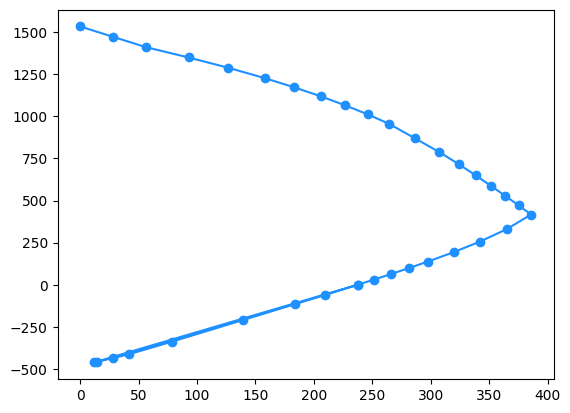

In [68]:
# Plot the values
plt.scatter(m / 12000, p / 1000, color="dodgerblue")
plt.plot(m / 12000, p / 1000, color="dodgerblue")

In [69]:
# Create a maxmin function:
def limit_min_max(value, min_limit, max_limit):
    return max(min(value, max_limit), min_limit)

In [70]:
min_value = 0.65
max_value = 0.85
value = 0.75
limit_min_max(value, min_value, max_value)

0.75

In [71]:
# Create function for axial_moment_reduction_factor()
def test_get_axial_moment_reduction_factor(strain_at_dt, rebar: rcmaterials.RebarMaterial, has_spirals: bool = False):
    phi_tens = 0.9
    phi_comp = 0.75 if has_spirals == True else 0.65
    coeff = 0.15 if has_spirals == True else 0.25
    return max(min(phi_comp + coeff * (strain_at_dt - -rebar.ey) / (-0.005 - -rebar.ey), phi_tens), phi_comp)

In [72]:
strain = -0.5
strain

-0.5

In [73]:
test_get_axial_moment_reduction_factor(strain, rebar, has_spirals = False)

0.9

<span style="color: dodgerblue;">**NOTE**:</span> Function returns the phi factor per ACI 318 Table 21.2.2

In [74]:
phis = rccolumn.get_multiple_axial_moment_reduction_factors(strains, rebar, has_spirals = False)
phis

array([0.65      , 0.65      , 0.65      , 0.65      , 0.65      ,
       0.65      , 0.65      , 0.65      , 0.65      , 0.65      ,
       0.65      , 0.65      , 0.65      , 0.65      , 0.65      ,
       0.65      , 0.65      , 0.65      , 0.65      , 0.72941176,
       0.81470588, 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       ])

In [75]:
design_p = p * phis
design_m = m * phis
design_p / 1000, design_m / 12000

(array([ 9.97100000e+02,  9.57216000e+02,  9.17332000e+02,  8.77448000e+02,
         8.37564000e+02,  7.97680000e+02,  7.62606000e+02,  7.27532000e+02,
         6.92458000e+02,  6.57384000e+02,  6.22310000e+02,  5.64924286e+02,
         5.13110000e+02,  4.65722329e+02,  4.21910000e+02,  3.81026867e+02,
         3.42573636e+02,  3.06158387e+02,  2.70891406e+02,  2.40203399e+02,
         2.08053467e+02,  1.75093333e+02,  1.23167763e+02,  8.86900824e+01,
         5.70508099e+01,  2.76369019e+01, -3.68803740e-11, -4.15879024e+02,
        -4.12114818e+02, -3.92229637e+02, -3.72344455e+02, -3.05222181e+02,
        -1.88944417e+02, -1.04797515e+02, -5.43111037e+01, -3.68803740e-11]),
 array([  0.        ,  18.28016667,  36.56033333,  60.29149195,
         82.44107246, 102.64309986, 118.89040529, 133.80562891,
        147.48037704, 160.01243121, 171.50526629, 186.28785544,
        199.47282843, 210.49328953, 220.05033974, 228.61163666,
        236.49499725, 243.91975642, 250.77437028, 266.0998

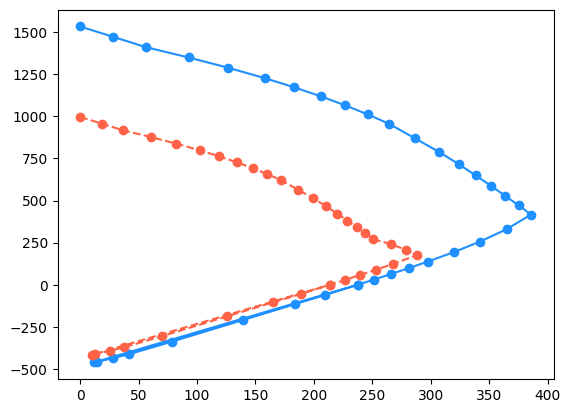

In [76]:
# Plot the values
plt.scatter(m / 12000, p / 1000, color="dodgerblue")
plt.plot(m / 12000, p / 1000, color="dodgerblue")

plt.scatter(design_m / 12000, design_p / 1000, color="tomato")
plt.plot(design_m / 12000, design_p / 1000, color="tomato", linestyle="dashed")
# plt.plot(design_m / 12000, design_p / 1000, color="tomato", linestyle="dashed")

In [77]:
design_ps, design_ms = rccolumn.get_design_pm_points(cs, bw, h, layer_distances, layer_areas, conc, rebar, has_spirals = False, is_capped = True)

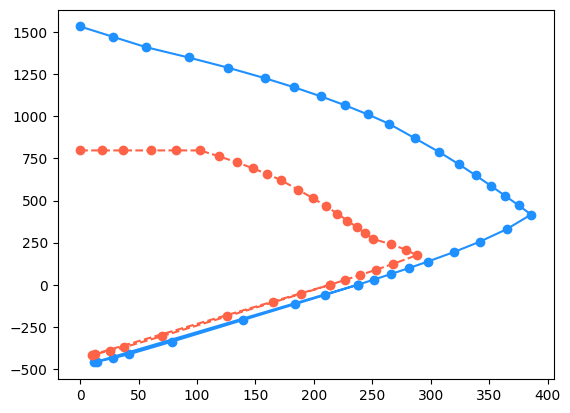

In [78]:
# Plot the values
plt.scatter(m / 12000, p / 1000, color="dodgerblue")
plt.plot(m / 12000, p / 1000, color="dodgerblue")

plt.scatter(design_ms / 12000, design_ps / 1000, color="tomato")
plt.plot(design_ms / 12000, design_ps / 1000, color="tomato", linestyle="dashed")
# plt.plot(design_m / 12000, design_p / 1000, color="tomato", linestyle="dashed")

In [79]:
design_ps / 1000

array([ 7.97680000e+02,  7.97680000e+02,  7.97680000e+02,  7.97680000e+02,
        7.97680000e+02,  7.97680000e+02,  7.62606000e+02,  7.27532000e+02,
        6.92458000e+02,  6.57384000e+02,  6.22310000e+02,  5.64924286e+02,
        5.13110000e+02,  4.65722329e+02,  4.21910000e+02,  3.81026867e+02,
        3.42573636e+02,  3.06158387e+02,  2.70891406e+02,  2.40203399e+02,
        2.08053467e+02,  1.75093333e+02,  1.23167763e+02,  8.86900824e+01,
        5.70508099e+01,  2.76369019e+01, -3.68803740e-11, -4.15879024e+02,
       -4.12114818e+02, -3.92229637e+02, -3.72344455e+02, -3.05222181e+02,
       -1.88944417e+02, -1.04797515e+02, -5.43111037e+01, -3.68803740e-11])

In [80]:
design_ms / 12000

array([  0.        ,  18.28016667,  36.56033333,  60.29149195,
        82.44107246, 102.64309986, 118.89040529, 133.80562891,
       147.48037704, 160.01243121, 171.50526629, 186.28785544,
       199.47282843, 210.49328953, 220.05033974, 228.61163666,
       236.49499725, 243.91975642, 250.77437028, 266.09981264,
       278.56158221, 288.06223611, 267.55582414, 253.13270985,
       239.44142706, 226.39509089, 213.91232021,  10.57037954,
        12.98757454,  25.43672255,  37.34744401,  70.37007296,
       125.38387453, 165.13260517, 188.91518389, 213.91232021])

In [81]:
cap_ps, cap_ms = rccolumn.get_design_pm_points(cs, bw, h, layer_distances, layer_areas, conc, rebar, has_spirals = False, is_capped = False)
cap_ps, cap_ms

(array([ 9.97100000e+05,  9.57216000e+05,  9.17332000e+05,  8.77448000e+05,
         8.37564000e+05,  7.97680000e+05,  7.62606000e+05,  7.27532000e+05,
         6.92458000e+05,  6.57384000e+05,  6.22310000e+05,  5.64924286e+05,
         5.13110000e+05,  4.65722329e+05,  4.21910000e+05,  3.81026867e+05,
         3.42573636e+05,  3.06158387e+05,  2.70891406e+05,  2.40203399e+05,
         2.08053467e+05,  1.75093333e+05,  1.23167763e+05,  8.86900824e+04,
         5.70508099e+04,  2.76369019e+04, -3.68803740e-08, -4.15879024e+05,
        -4.12114818e+05, -3.92229637e+05, -3.72344455e+05, -3.05222181e+05,
        -1.88944417e+05, -1.04797515e+05, -5.43111037e+04, -3.68803740e-08]),
 array([      0.        ,  219362.0000009 ,  438723.9999992 ,
         723497.90341263,  989292.86957581, 1231717.19836833,
        1426684.8635028 , 1605667.54697006, 1769764.52452812,
        1920149.17449806, 2058063.19542088, 2235454.26530612,
        2393673.94117647, 2525919.47438544, 2640604.07692308,
    

In [82]:
z_mmax = rccolumn.get_z_at_pure_m(bw, h, layer_distances, layer_areas, conc, rebar)
z_mmax

-4.574536344416801

In [83]:
c_mmax = rccolumn.c_from_z(z_mmax, max(layer_distances), conc, rebar)
c_mmax

3.249212699686176

In [84]:
points = 9
cs = np.linspace(0, c_mmax, points)
cs

array([0.        , 0.40615159, 0.81230317, 1.21845476, 1.62460635,
       2.03075794, 2.43690952, 2.84306111, 3.2492127 ])

In [85]:
zs = np.zeros(points)
for i in range(points):
    zs[i] = rccolumn.z_from_c(cs[i], max(layer_distances), conc, rebar)
zs

array([-58.        , -46.74629076, -22.64814538, -14.61543025,
       -10.59907269,  -8.18925815,  -6.58271513,  -5.43518439,
        -4.57453634])

In [86]:
c_x = 2
p_x, m_x, e_x = rccolumn.pm_points(c_x, bw, h, layer_distances, layer_areas, conc, rebar)

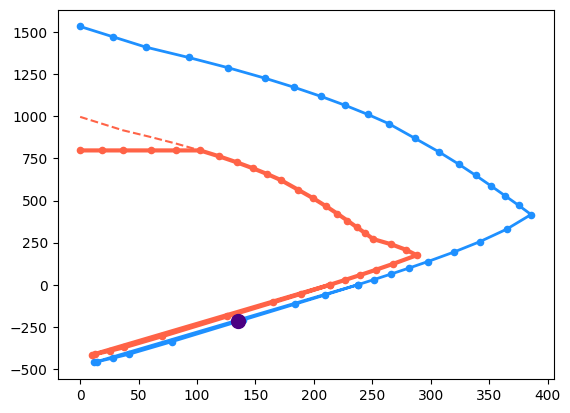

In [87]:
# Plot the values
plt.scatter(m / 12000, p / 1000, color="dodgerblue", s=20)
plt.plot(m / 12000, p / 1000, color="dodgerblue", linewidth=2)

plt.scatter(design_ms / 12000, design_ps / 1000, color="tomato", s=20)
plt.plot(design_ms / 12000, design_ps / 1000, color="tomato", linewidth=3)

# Capped portion as dashed lined
plt.plot(cap_ms / 12000, cap_ps / 1000, color="tomato", linestyle="dashed", zorder = -1)

# Individual Points
plt.scatter(m_x / 12000, p_x / 1000, color="indigo", s=100, zorder=10)